## Análisis del laboratorio de masa

In [350]:
# Import necessary libraries
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np


In [351]:
# Import custom libraries
import warnings
import sys
import os

# Subir dos niveles desde notebooks/mod_tecnico/ hasta la raíz del repo
repo_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))  
sys.path.append(repo_path)

# Ahora intenta importar
from src.data_processing import ready_to_import


In [352]:
#Importar librerias para graficar
from matplotlib import pyplot as plt
import seaborn as sns

In [353]:
import sys
!{sys.executable} -m pip install pandasql --user

"c:\Users\Miguel" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


#### Importamos lo necesario para trabajar con consultas SQL

In [354]:
from pandasql import sqldf
print("¡Listo para usar SQL en pandas!")
from pandasql import sqldf

# Definir función de consulta
pysqldf = lambda q: sqldf(q, globals())

¡Listo para usar SQL en pandas!


In [355]:
# Import data
# Import data from Excel files
masa = pd.read_excel('C:/Users/Miguel Oscar/Projects/data-INSCO-hub/data/raw/masa.xlsx')

In [356]:
# Resumen estadístico de la tabla
masa.describe()

,lab_received_date,scheduled_delivery_date,cleaning_date,calibration_date,delivery_date,delivery_time,assigned_time,piece_count
count,461,454,474,475,480,480.000000,480.000000,480.000000
mean,2025-01-30 01:11:50.629067264,2025-02-18 17:48:53.920704768,2025-01-31 00:57:43.291139328,2025-02-09 17:59:14.526315776,2025-02-15 04:06:00,8.645833,12.291667,4.985417
min,2024-11-06 00:00:00,2024-12-19 00:00:00,2024-03-12 00:00:00,2024-03-13 00:00:00,2025-01-02 00:00:00,0.000000,0.000000,1.000000
25%,2025-01-14 00:00:00,2025-01-31 00:00:00,2025-01-13 00:00:00,2025-01-23 00:00:00,2025-01-24 00:00:00,5.000000,11.000000,1.000000
50%,2025-01-28 00:00:00,2025-02-18 00:00:00,2025-01-29 00:00:00,2025-02-10 00:00:00,2025-02-11 00:00:00,8.000000,13.000000,1.000000
75%,2025-02-25 00:00:00,2025-03-13 00:00:00,2025-02-28 00:00:00,2025-03-08 12:00:00,2025-03-11 00:00:00,11.000000,15.000000,3.000000
max,2025-03-27 00:00:00,2025-04-04 00:00:00,2025-03-28 00:00:00,2025-03-31 00:00:00,2025-03-31 00:00:00,44.000000,30.000000,58.000000
std,NaN,NaN,NaN,NaN,NaN,5.931374,5.242584,8.438021


**Podemos notar que hay columnas que tienen mal el tipo de variable**<br>
**Se debe cambiar las columnas que contienen fechas al tipo 'datetime'**

In [357]:
# Ver los tipos de datos de cada columna con más detalle
masa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586 entries, 0 to 585
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            461 non-null    object        
 1   so                       480 non-null    object        
 2   assignee                 586 non-null    object        
 3   calibrator               479 non-null    object        
 4   supervisor               480 non-null    object        
 5   approver                 478 non-null    object        
 6   classification           463 non-null    object        
 7   lab_received_date        461 non-null    datetime64[ns]
 8   scheduled_delivery_date  454 non-null    datetime64[ns]
 9   cleaning_date            474 non-null    datetime64[ns]
 10  calibration_date         475 non-null    datetime64[ns]
 11  delivery_date            480 non-null    datetime64[ns]
 12  delivery_time            480 non-nul

In [358]:
# Seleccionamos las columnas que contienen fechas y las convertimos a tipo datetime
col_fechas = [col for col in masa.columns if 'date' in col.lower() or 'fecha' in col.lower()]

for col in col_fechas:
    masa[col] = pd.to_datetime(masa[col], errors='coerce', format='%Y/%m/%d')

In [359]:
masa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586 entries, 0 to 585
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            461 non-null    object        
 1   so                       480 non-null    object        
 2   assignee                 586 non-null    object        
 3   calibrator               479 non-null    object        
 4   supervisor               480 non-null    object        
 5   approver                 478 non-null    object        
 6   classification           463 non-null    object        
 7   lab_received_date        461 non-null    datetime64[ns]
 8   scheduled_delivery_date  454 non-null    datetime64[ns]
 9   cleaning_date            474 non-null    datetime64[ns]
 10  calibration_date         475 non-null    datetime64[ns]
 11  delivery_date            480 non-null    datetime64[ns]
 12  delivery_time            480 non-nul

In [360]:
# Se hace una copia de la tabla para evitar problemas de referencia
mass = masa.copy()

**Se eliminan las filas donde 'report_number' es NaN y se une el contenido de 'assignee' de las filas con 'report_number' NaN a la fila anterior**

In [361]:
# Esta función es interna y creada para el proceso en el que se va a usar
mass = ready_to_import.to_prepare_db(mass)

In [362]:
# Verificamos nuevamente los tipos de datos de cada columna y la cantidad de datos nulos
mass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461 entries, 0 to 460
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            461 non-null    object        
 1   so                       461 non-null    object        
 2   assignee                 461 non-null    object        
 3   calibrator               460 non-null    object        
 4   supervisor               461 non-null    object        
 5   approver                 459 non-null    object        
 6   classification           444 non-null    object        
 7   lab_received_date        461 non-null    datetime64[ns]
 8   scheduled_delivery_date  454 non-null    datetime64[ns]
 9   cleaning_date            455 non-null    datetime64[ns]
 10  calibration_date         456 non-null    datetime64[ns]
 11  delivery_date            461 non-null    datetime64[ns]
 12  delivery_time            461 non-nul

### Comparamos la cantidad de calibraciones con los mantenimientos

In [363]:
# Clasificar por tipo de servicio
mass['service_type'] = np.where(
    mass['report_number'].str.startswith('RSM', na=False),
    'Mantenimiento',
    np.where(
        mass['report_number'].str.startswith('CCM', na=False),
        'Calibración',
        'Otros'  # Valor por defecto si ninguna condición se cumple
    )
)

In [364]:
service_type = mass['service_type'].value_counts()
service_type

service_type
Calibración      387
Mantenimiento     74
Name: count, dtype: int64

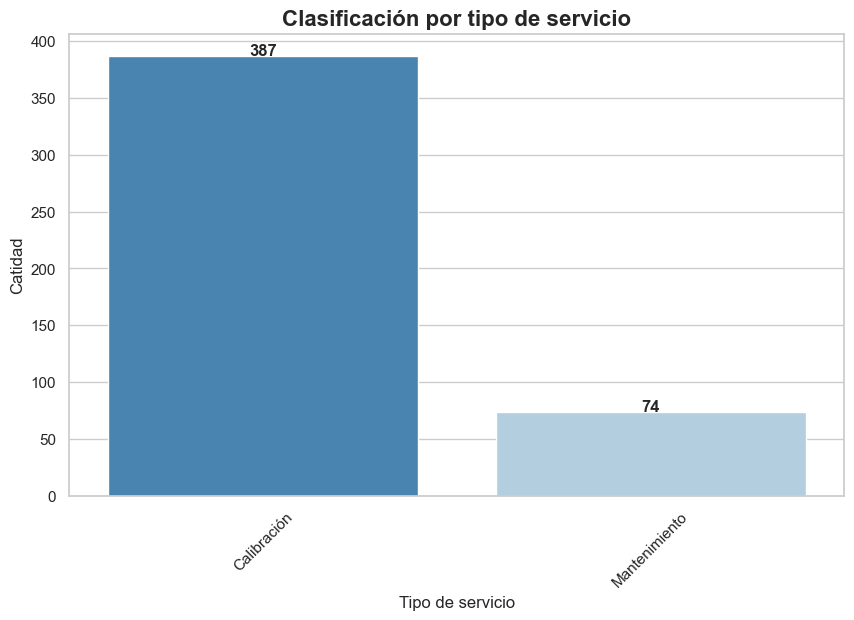

In [365]:
# Crear figura
plt.figure(figsize=(10, 6))

# Gráfico de barras con Seaborn
ax = sns.barplot(x=service_type.index, y=service_type.values, hue=service_type.index, palette='Blues_r', legend=False)

# Rotar etiquetas del eje X
plt.xticks(rotation=45)

# Etiquetas de los ejes
plt.xlabel('Tipo de servicio')
plt.ylabel('Catidad')
plt.title('Clasificación por tipo de servicio', fontsize=16, fontweight='bold')

# Agregar etiquetas en las barras
for i, v in enumerate(service_type.values):
    ax.text(i, v + 0.05, str(v), ha='center', fontsize=12, fontweight='bold')

# Mostrar gráfico
plt.show()

#### Añadir una columna para clasificar los equipos por tipos

In [366]:
classification_map = {
    'I': 'Balanza', 'II': 'Balanza', 'III': 'Balanza', 'IIII': 'Balanza',
    'E1': 'Pesa OIML', 'E2': 'Pesa OIML', 'F1': 'Pesa OIML', 'F2': 'Pesa OIML',
    'M1': 'Pesa OIML', 'M2': 'Pesa OIML', 'M3': 'Pesa OIML',
    '1': 'Pesa ASTM', '2': 'Pesa ASTM', '3': 'Pesa ASTM', '4': 'Pesa ASTM',
    '5': 'Pesa ASTM', '6': 'Pesa ASTM',
    'M': 'NBS', 'S': 'NBS', 'S-1': 'NBS', 'P': 'NBS', 'Q': 'NBS',
    'T': 'NBS', 'F': 'NBS',
    'ONN': 'ONN'
}

# Asignar valores usando map()
mass['equipment_type'] = mass['classification'].map(classification_map).fillna('Otros')

#### Analicemos brevemente los mantenimientos

In [367]:
maintenance_per_type = mass_maintenance.groupby('equipment_type')['report_number'].count().sort_values(ascending=False)
maintenance_per_type

equipment_type
Pesa OIML    50
Otros        17
Balanza       7
Name: report_number, dtype: int64

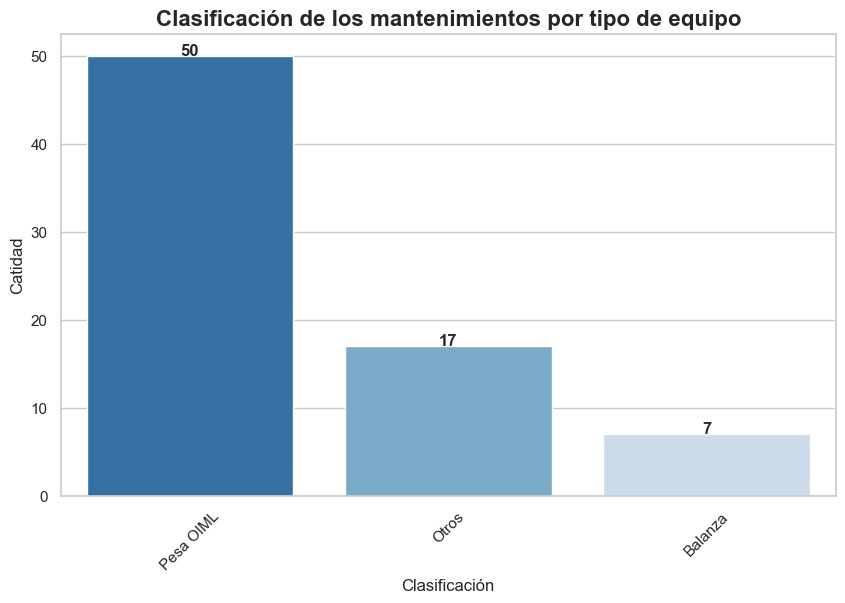

In [368]:
# Crear figura
plt.figure(figsize=(10, 6))

# Gráfico de barras con Seaborn
ax = sns.barplot(x=maintenance_per_type.index, y=maintenance_per_type.values, hue=maintenance_per_type.index, palette='Blues_r', legend=False)

# Rotar etiquetas del eje X
plt.xticks(rotation=45)

# Etiquetas de los ejes
plt.xlabel('Clasificación')
plt.ylabel('Catidad')
plt.title('Clasificación de los mantenimientos por tipo de equipo', fontsize=16, fontweight='bold')

# Agregar etiquetas en las barras
for i, v in enumerate(maintenance_per_type.values):
    ax.text(i, v + 0.05, str(v), ha='center', fontsize=12, fontweight='bold')

# Mostrar gráfico
plt.show()

In [369]:
# Cantidad de mantenimientos por clasificación
maintenance_class = mass_maintenance.groupby('classification')['report_number'].count().sort_values(ascending=False)
maintenance_class

classification
M1     49
I       3
II      3
III     1
M2      1
Name: report_number, dtype: int64

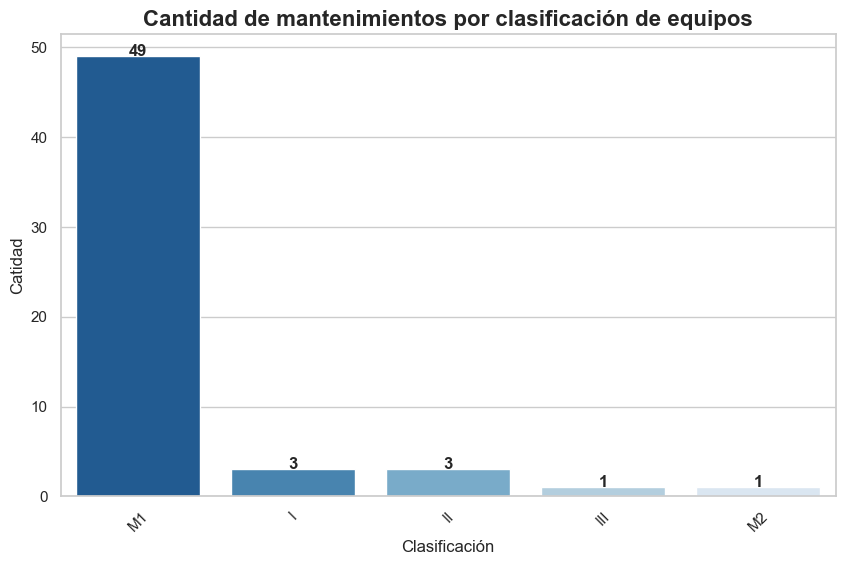

In [370]:
# Crear figura
plt.figure(figsize=(10, 6))

# Gráfico de barras con Seaborn
ax = sns.barplot(x=maintenance_class.index, y=maintenance_class.values, hue=maintenance_class.index, palette='Blues_r', legend=False)

# Rotar etiquetas del eje X
plt.xticks(rotation=45)

# Etiquetas de los ejes
plt.xlabel('Clasificación')
plt.ylabel('Catidad')
plt.title('Cantidad de mantenimientos por clasificación de equipos', fontsize=16, fontweight='bold')

# Agregar etiquetas en las barras
for i, v in enumerate(maintenance_class.values):
    ax.text(i, v + 0.05, str(v), ha='center', fontsize=12, fontweight='bold')

# Mostrar gráfico
plt.show()

In [371]:
maintenance_per_met = (mass_maintenance.groupby(['calibrator', 'equipment_type'])
                                               .size()
                                               .unstack(fill_value=0)
                                               #.reset_index()
                                               )
maintenance_per_met

equipment_type,Balanza,Otros,Pesa OIML
calibrator,,,
Francisco Torres Cabrera,5,1,0
Guillermo Guzmán López,2,0,2
Mario de Jesús García,0,16,43
Sergio Cruz Santiago,0,0,4


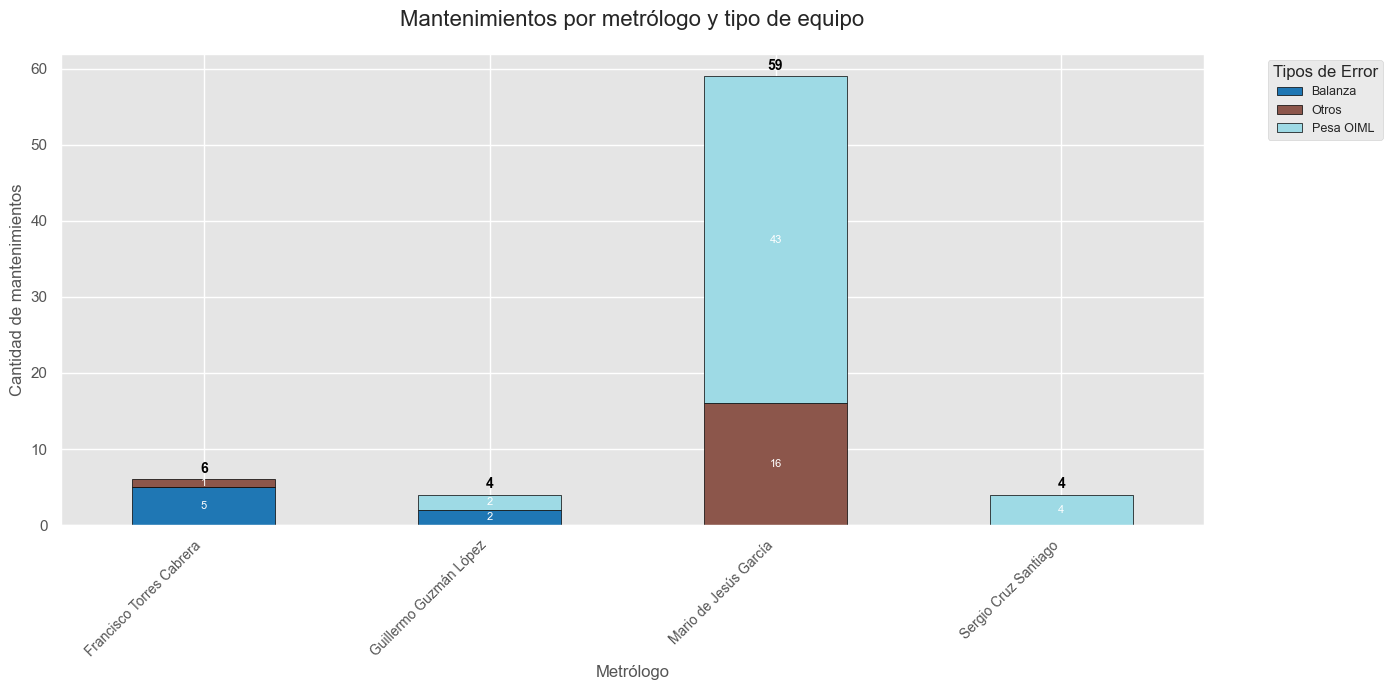

In [372]:
# Configurar el estilo
plt.style.use('ggplot')

# Crear gráfico de barras apiladas
ax = maintenance_per_met.plot(
    kind='bar', 
    stacked=True,
    figsize=(14, 7),
    colormap='tab20',
    edgecolor='black',
    linewidth=0.5
)

# Calcular totales por barra
totales = maintenance_per_met.sum(axis=1)

# Añadir etiquetas de totales ENCIMA de las barras
for i, total in enumerate(totales):
    ax.text(
        x=i,                         # Posición en el eje X
        y=total + 0.5,                # Altura: total + margen
        s=f'{int(total)}',            # Texto a mostrar
        ha='center',                  # Alineación horizontal
        va='bottom',                  # Alineación vertical
        fontsize=10,
        color='black',
        weight='bold'                 # Texto en negrita
    )

# Añadir etiquetas individuales (segmentos)
for rect in ax.patches:
    height = rect.get_height()
    if height > 0:
        ax.text(
            rect.get_x() + rect.get_width()/2, 
            rect.get_y() + height/2, 
            f'{int(height)}', 
            ha='center', 
            va='center',
            fontsize=8,
            color='white'             # Color contrastante para segmentos
        )

# Personalización adicional (manteniendo el resto del código)
plt.title('Mantenimientos por metrólogo y tipo de equipo', fontsize=16, pad=20)
plt.xlabel('Metrólogo', fontsize=12)
plt.ylabel('Cantidad de mantenimientos', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Tipos de Error', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()

**Realizar análisis de los tiempos de los mantenimientos**

In [373]:
maintenance_time = (mass_maintenance.groupby('equipment_type')[['delivery_time', 'assigned_time', 'piece_count']]
                                               .mean()
                                               #.unstack(fill_value=0)
                                               #.reset_index()
                                               )  

'''maintenance_time = maintenance_time.rename(
    columns={
        'Tiempo_Entrega': 'delivery_time' ,
        'Tiempo_Asignación':'assigned_time',
        'Cantidad_Piezas':'piece_count'
    }
)'''
maintenance_time

,delivery_time,assigned_time,piece_count
equipment_type,,,
Balanza,2.857143,3.571429,1.000000
Otros,6.529412,12.647059,1.588235
Pesa OIML,8.860000,14.640000,3.760000


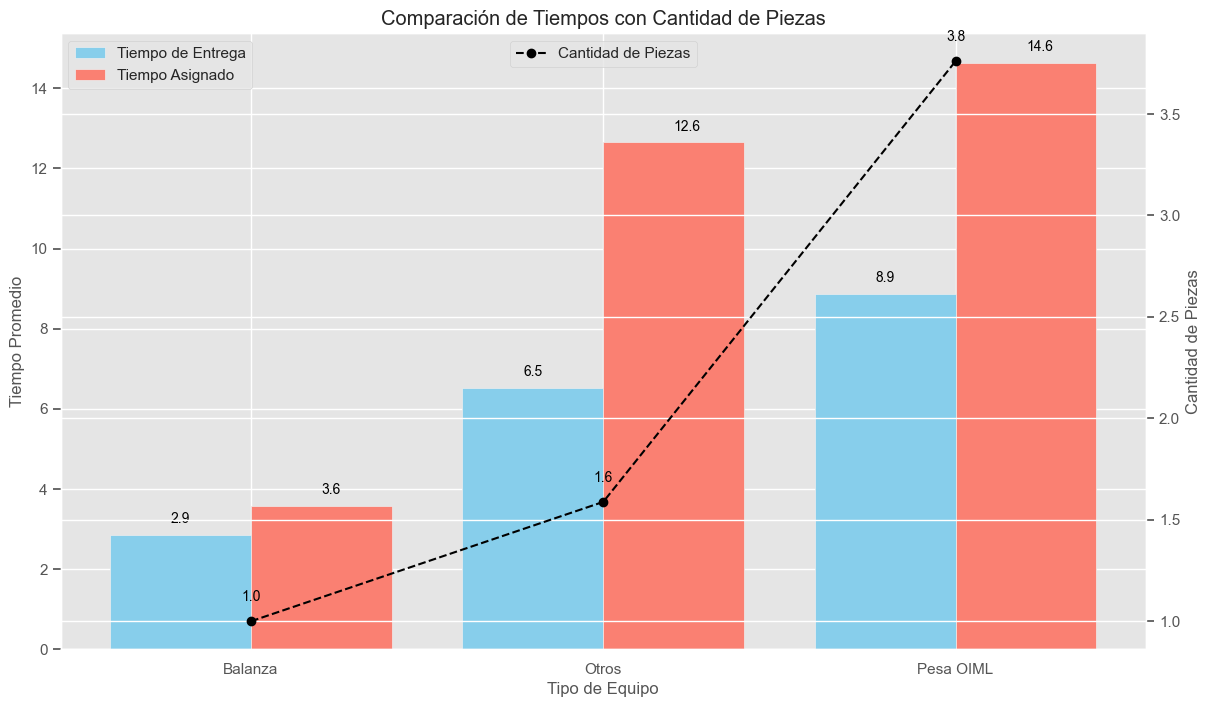

In [374]:
df = maintenance_time.reset_index()

# Configurar figura y ejes
fig, ax1 = plt.subplots(figsize=(14, 8))

# Ancho de las barras
bar_width = 0.4
x = range(len(df))

# Barras agrupadas
bars1 = ax1.bar(x, df['delivery_time'], width=bar_width, color='skyblue', label='Tiempo de Entrega', align='center')
bars2 = ax1.bar([i + bar_width for i in x], df['assigned_time'], width=bar_width, color='salmon', label='Tiempo Asignado', align='center')

# Segundo eje Y para la cantidad de piezas
ax2 = ax1.twinx()
points = ax2.plot([i + bar_width/2 for i in x], df['piece_count'], color='black', marker='o', label='Cantidad de Piezas', linestyle='dashed')

# Etiquetas en las barras
for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, f'{bar.get_height():.1f}', ha='center', fontsize=10, color='black')
for bar in bars2:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, f'{bar.get_height():.1f}', ha='left', fontsize=10, color='black')

# Etiquetas en los puntos de cantidad de piezas
for i, txt in enumerate(df['piece_count']):
    ax2.text(i + bar_width/2, txt + 0.1, f'{txt:.1f}', ha='center', fontsize=10, color='black')

# Configurar etiquetas en el eje X
ax1.set_xticks([i + bar_width/2 for i in x])
ax1.set_xticklabels(df['equipment_type'])

# Etiquetas y título
ax1.set_ylabel("Tiempo Promedio")
ax2.set_ylabel("Cantidad de Piezas")
ax1.set_xlabel("Tipo de Equipo")
ax1.set_title("Comparación de Tiempos con Cantidad de Piezas")

# Leyendas
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')

plt.show()


# Realizar el análisis de las calibraciones

### Eliminamos todos los reportes que no son calibraciones

In [375]:
# Se eliminan las filas que no son calibraciones
mass_cal = mass[~mass['report_number'].str.startswith('RSM', na=False)]

In [376]:
mass_cal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 387 entries, 0 to 386
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            387 non-null    object        
 1   so                       387 non-null    object        
 2   assignee                 387 non-null    object        
 3   calibrator               387 non-null    object        
 4   supervisor               387 non-null    object        
 5   approver                 385 non-null    object        
 6   classification           387 non-null    object        
 7   lab_received_date        387 non-null    datetime64[ns]
 8   scheduled_delivery_date  382 non-null    datetime64[ns]
 9   cleaning_date            381 non-null    datetime64[ns]
 10  calibration_date         387 non-null    datetime64[ns]
 11  delivery_date            387 non-null    datetime64[ns]
 12  delivery_time            387 non-null    

# Análisis Exploratorio de Datos (EDA)

## Estructura General del DataFrame
- **Filas**: 387 registros.
- **Columnas**: 21 en total.
- **Tipos de datos**:
  - `datetime64[ns]`: 5 columnas (fechas).
  - `float64`: 3 columnas (valores numéricos).
  - `object`: 13 columnas (texto/categorías).

---

## Valores Faltantes por Columna
| Columna                   | No. Faltantes | % Faltantes | Observación                           |
|---------------------------|---------------|-------------|---------------------------------------|
| `approver`                | 2             | 0.52%       | Datos casi completos                 |
| `scheduled_delivery_date` | 5             | 1.29%       |                                      |
| `cleaning_date`           | 6             | 1.55%       |                                      |
| `substitution_reason`     | 364           | **94.06%**  | Datos extremadamente escasos         |
| `lab_observations`        | 336           | **86.82%**  | Campo poco documentado               |

**Acciones sugeridas**:  
- Eliminar columnas `substitution_reason` y `lab_observations` por alta tasa de faltantes (>85%).  
- Imputar valores en columnas con pocos faltantes (ej: `approver`).  

---

## Columnas Temporales Clave
- **Fechas críticas**:
  - `lab_received_date`: Recepción en laboratorio.
  - `scheduled_delivery_date`: Entrega programada.
  - `delivery_date`: Entrega real.
  - `calibration_date`: Fecha de calibración.

**Análisis sugerido**:  
- Calcular retrasos: `delivery_date - scheduled_delivery_date`.  
- Tiempo total de proceso: `delivery_date - lab_received_date`.  

---

## Variables Numéricas
- **Columnas**:
  - `delivery_time`: Tiempo de entrega (unidades no especificadas).
  - `assigned_time`: Tiempo de asignación.
  - `piece_count`: Cantidad de piezas.

**Recomendaciones**:  
- Buscar **outliers** usando boxplots (ej: `delivery_time` anormalmente alto).  
- Analizar correlación entre `piece_count` y tiempos de proceso.  

---

## Variables Categóricas Clave
- **Personal**:
  - `assignee`, `calibrator`, `supervisor`: Evaluar carga de trabajo.  
- **Operacionales**:
  - `priority`: Prioridad del servicio ("URGENTE", "ORDINARIO").  
  - `service_location`: Ubicación del servicio ("LAB", "SITIO").  
  - `process_status`: Estado del proceso.

**Segmentación sugerida**:  
- Comparar métricas por `priority` y `service_location`.  

---

## Pasos Siguientes
1. **Limpieza de datos**:  
   - Eliminar columnas redundantes (`substitution_reason`, `lab_observations`).  
   - Validar consistencia temporal (ej: ¿`cleaning_date` ≤ `calibration_date`?).  

2. **Análisis de retrasos**:  
   - Crear columna `delay_days` para cuantificar incumplimientos.  

3. **Visualización**:  
   - Heatmap de correlación entre variables numéricas.  
   - Gráfico de barras apiladas para `process_status` por `priority`.  

4. **Optimización**:  
   - Identificar asignados (`assignee`) con mayor carga usando `piece_count` y `assigned_time`.  

**Objetivo final**: Mejorar la eficiencia operativa y reducir tiempos de entrega.  

# Análisis de los errores de sustitución

In [377]:
# Eliminamos la columna 'service_type' y obtenemos la cantidad de reportes por cada razón de sustitución
mass_cal = mass_cal.drop(columns=['service_type'], axis=1)
subs_reason = mass_cal.groupby('substitution_reason')['report_number'].count().sort_values(ascending=False)
subs_reason


substitution_reason
Solicitud del cliente           14
Error de laboratorio             6
Error del área comercial         2
Error de atención al cliente     1
Name: report_number, dtype: int64

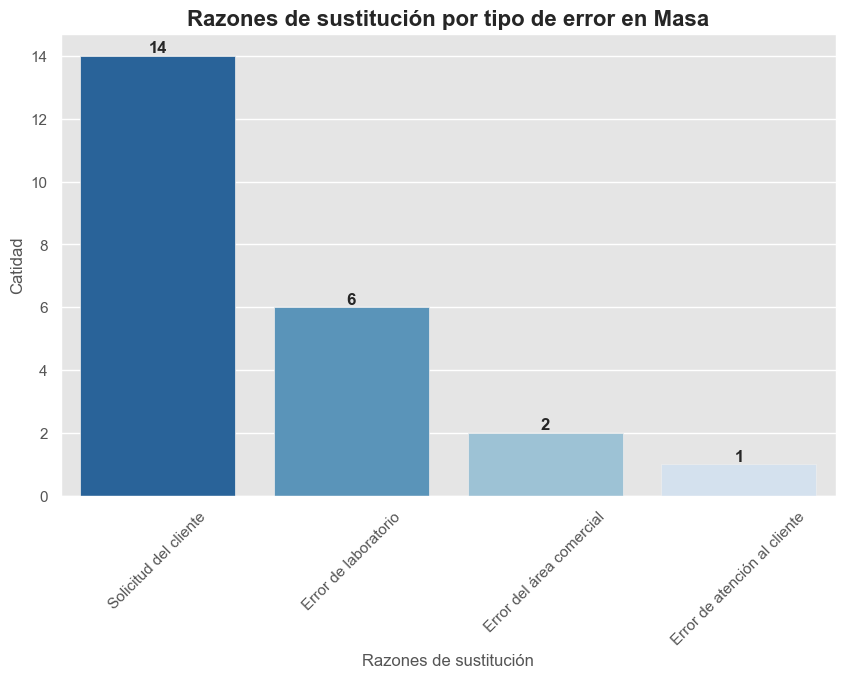

In [378]:
# Crear figura
plt.figure(figsize=(10, 6))

# Gráfico de barras con Seaborn
ax = sns.barplot(x=subs_reason.index, y=subs_reason.values, hue=subs_reason.index, palette='Blues_r', legend=False)

# Rotar etiquetas del eje X
plt.xticks(rotation=45)

# Etiquetas de los ejes
plt.xlabel('Razones de sustitución')
plt.ylabel('Catidad')
plt.title('Razones de sustitución por tipo de error en Masa', fontsize=16, fontweight='bold')

# Agregar etiquetas en las barras
for i, v in enumerate(subs_reason.values):
    ax.text(i, v + 0.1, str(v), ha='center', fontsize=12, fontweight='bold')

# Mostrar gráfico
plt.show()


#### Clasificación por metrólogo y tipos de errores

In [379]:
# Agrupar por 'assignee' y contar errores por tipo de 'substitution_reason'
errores_por_assignee = (
    mass.groupby(['assignee', 'substitution_reason'])  # Agrupar por persona y tipo de error
        .size()                                   # Contar ocurrencias
        .unstack(fill_value=0)                    # Convertir a formato tabla
        .reset_index()                            # Convertir índice a columna
)

# Ordenar por el total de errores (opcional)
errores_por_assignee['Total'] = errores_por_assignee.count(axis=1)
errores_por_assignee = errores_por_assignee.sort_values('Total', ascending=False).drop('Total', axis=1)

# Mostrar resultado
errores_por_assignee

substitution_reason,assignee,Error de atención al cliente,Error de laboratorio,Error del área comercial,Solicitud del cliente
0,Eva María Arévalo Jiménez,1,0,0,8
1,Francisco Torres Cabrera,0,3,1,0
2,Gabriel Gallardo Camacho,0,0,0,2
3,Guillermo Guzmán López,0,0,0,2
4,Leobardo Maximiliano Brito Fonseca,0,2,1,0
5,Mario de Jesús García,0,1,0,4


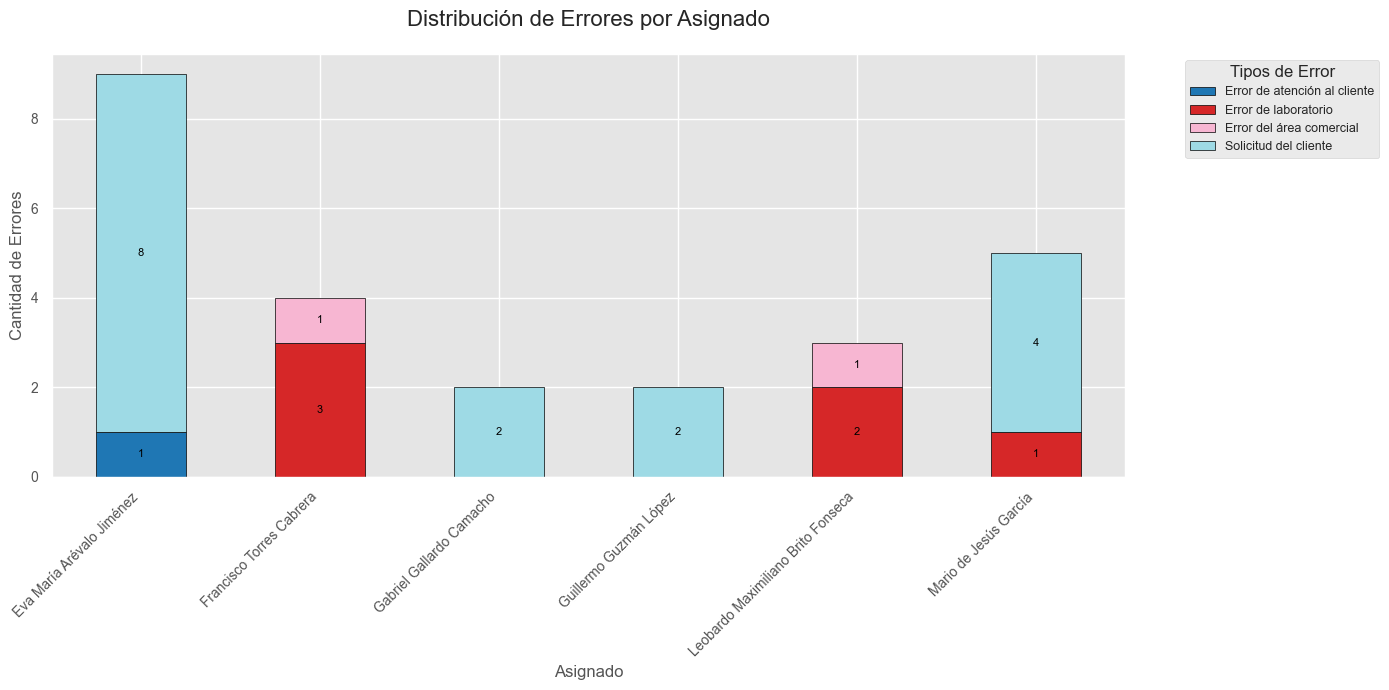

In [380]:
# Configurar el estilo
plt.style.use('ggplot')

# Crear gráfico de barras apiladas
ax = errores_por_assignee.set_index('assignee').plot(
    kind='bar', 
    stacked=True,
    figsize=(14, 7),
    colormap='tab20',  # Paleta de colores para múltiples categorías
    edgecolor='black',
    linewidth=0.5
)

# Personalizar el gráfico
plt.title('Distribución de Errores por Asignado', fontsize=16, pad=20)
plt.xlabel('Asignado', fontsize=12)
plt.ylabel('Cantidad de Errores', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Añadir etiquetas de totales
for rect in ax.patches:
    height = rect.get_height()
    if height > 0:  # Mostrar solo etiquetas para barras con valores
        ax.text(rect.get_x() + rect.get_width()/2, 
                rect.get_y() + height/2, 
                f'{int(height)}', 
                ha='center', 
                va='center',
                fontsize=8,
                color='black')

# Mejorar la leyenda
plt.legend(
    title='Tipos de Error',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=9,
    frameon=True
)

# Ajustar márgenes
plt.tight_layout()
plt.show()

#### Tipos de errores vs Clasificación de equipo

In [381]:
# 1. Crear una copia del DataFrame para preservar los datos originales
df_temp = mass_cal.copy()

# 2. Identificar errores no clasificados (NaN)
df_temp['classification'] = df_temp['classification'].fillna('No clasificado')  # Renombrar NaN

# 3. Agrupar incluyendo la nueva categoría
errores_por_classification = (
    df_temp.groupby(['classification', 'substitution_reason'])
        .size()
        .unstack(fill_value=0)
        .reset_index()
)

# 4. Calcular el TOTAL correcto (suma de razones)
columnas_errores = errores_por_classification.columns.difference(['classification'])
errores_por_classification['Total'] = errores_por_classification[columnas_errores].sum(axis=1)

# 5. Ordenar y mostrar
errores_por_classification = errores_por_classification.sort_values('Total', ascending=False)
errores_por_classification

substitution_reason,classification,Error de atención al cliente,Error de laboratorio,Error del área comercial,Solicitud del cliente,Total
0,E2,1,3,2,7,13
1,F1,0,3,0,5,8
2,M2,0,0,0,2,2


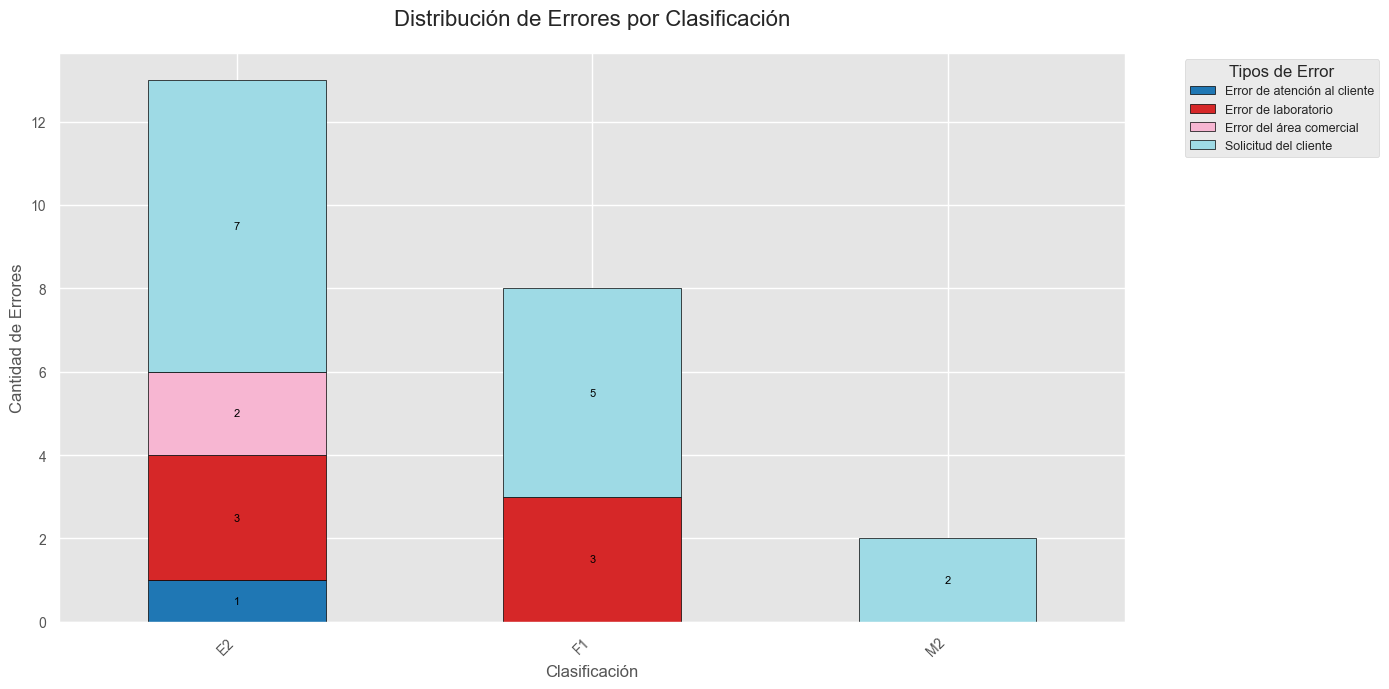

In [382]:
# Configurar el estilo
plt.style.use('ggplot')

# Crear gráfico de barras apiladas
errores_por_classification = errores_por_classification.drop(columns='Total', errors='ignore')  # Eliminar la columna 'Total' para el gráfico
ax = errores_por_classification.set_index('classification').plot(
    kind='bar', 
    stacked=True,
    figsize=(14, 7),
    colormap='tab20',  # Paleta de colores para múltiples categorías
    edgecolor='black',
    linewidth=0.5
)

# Personalizar el gráfico
plt.title('Distribución de Errores por Clasificación', fontsize=16, pad=20)
plt.xlabel('Clasificación', fontsize=12)
plt.ylabel('Cantidad de Errores', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Añadir etiquetas de totales
for rect in ax.patches:
    height = rect.get_height()
    if height > 0:  # Mostrar solo etiquetas para barras con valores
        ax.text(rect.get_x() + rect.get_width()/2, 
                rect.get_y() + height/2, 
                f'{int(height)}', 
                ha='center', 
                va='center',
                fontsize=8,
                color='black')

# Mejorar la leyenda
plt.legend(
    title='Tipos de Error',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=9,
    frameon=True
)

# Ajustar márgenes
plt.tight_layout()
plt.show()

#### Eliminar las filas que contienen los informes que corresponden a las sustituciones por errores

In [383]:
mass_sin_errores = df_temp.drop(df_temp[df_temp['substitution_reason'].notna()].index)

In [384]:
mass_sin_errores.loc[mass_sin_errores['report_number'] == 'CCM0095.M/2025', 'piece_count'] = 95

In [385]:
mass_sin_errores = mass_sin_errores.drop(columns=['substitution_reason'], errors='ignore')
mass_sin_errores.head(10)

,report_number,so,assignee,calibrator,supervisor,approver,classification,lab_received_date,scheduled_delivery_date,cleaning_date,calibration_date,delivery_date,delivery_time,process_status,assigned_time,service_location,lab_observations,priority,piece_count,equipment_type
0,CCM0001.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,2025-01-10,2025-01-10,24.0,ENTREGADO,20.0,LAB,NaN,ORDINARIO,1.0,Pesa OIML
1,CCM0002.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,2025-01-10,2025-01-10,24.0,ENTREGADO,20.0,LAB,NaN,ORDINARIO,1.0,Pesa OIML
2,CCM0003.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,2025-01-10,2025-01-10,24.0,ENTREGADO,20.0,LAB,NaN,ORDINARIO,1.0,Pesa OIML
3,CCM0004.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,2025-01-10,2025-01-10,24.0,ENTREGADO,20.0,LAB,NaN,ORDINARIO,1.0,Pesa OIML
4,CCM0005.M/2025 v0,I0082,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2025-01-21,2025-01-31,2025-01-21,2025-01-30,2025-01-30,7.0,ENTREGADO,8.0,LAB,Me dan otra pesa para calibrarla y esta si cum...,ORDINARIO,1.0,Pesa OIML
5,CCM0005.M/2025 v1,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,2025-01-10,2025-01-10,24.0,ENTREGADO,20.0,LAB,Pesa de venta no cumple con la clese E2. cuand...,ORDINARIO,1.0,Pesa OIML
6,CCM0006.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,2025-01-10,2025-01-10,24.0,ENTREGADO,20.0,LAB,NaN,ORDINARIO,1.0,Pesa OIML
7,CCM0007.M/2025,H2395,Francisco Torres Cabrera,Francisco Torres Cabrera,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,E2,2024-12-06,2025-01-08,2024-12-06,2025-01-07,2025-01-07,20.0,ENTREGADO,21.0,LAB,NaN,ORDINARIO,22.0,Pesa OIML
8,CCM0008.M/2025,H2403,Guillermo Guzmán López,Guillermo Guzmán López,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2024-12-09,2025-01-06,2025-01-02,2025-01-06,2025-01-06,18.0,ENTREGADO,18.0,LAB,NaN,ORDINARIO,4.0,Pesa OIML
9,CCM0009.M/2025,H2403,Guillermo Guzmán López,Guillermo Guzmán López,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2024-12-09,2025-01-06,2025-01-02,2025-01-06,2025-01-06,18.0,ENTREGADO,18.0,LAB,NaN,ORDINARIO,3.0,Pesa OIML


In [386]:
# Eliminamos las columnas que no son necesarias
mass_sin_errores = mass_sin_errores.drop(columns=['substitution_reason', 'service_type', 'lab_observations', 'process_status'], errors='ignore')

In [387]:
mass_sin_errores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 364 entries, 0 to 386
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            364 non-null    object        
 1   so                       364 non-null    object        
 2   assignee                 364 non-null    object        
 3   calibrator               364 non-null    object        
 4   supervisor               364 non-null    object        
 5   approver                 362 non-null    object        
 6   classification           364 non-null    object        
 7   lab_received_date        364 non-null    datetime64[ns]
 8   scheduled_delivery_date  359 non-null    datetime64[ns]
 9   cleaning_date            358 non-null    datetime64[ns]
 10  calibration_date         364 non-null    datetime64[ns]
 11  delivery_date            364 non-null    datetime64[ns]
 12  delivery_time            364 non-null    

#### Comenzamos a trabajar sobre esta nueva tabla

In [407]:
# Verificamos los valores nulos de la columna 'approver' en la tabla

resultado = pysqldf("""
    SELECT *
    FROM mass_sin_errores
    WHERE approver IS NULL """)

resultado

,report_number,so,assignee,calibrator,supervisor,approver,classification,lab_received_date,scheduled_delivery_date,cleaning_date,calibration_date,delivery_date,delivery_time,assigned_time,service_location,priority,piece_count,equipment_type


In [389]:
#Cambiar el valor de la columna approver a 'Gabriel Gallardo Camacho' para el report_number específico
mass_sin_errores.loc[mass_sin_errores['report_number'].isin(['CCM0049.M/2025', 'CCM0050.M/2025']), 'approver'] = 'Gabriel Gallardo Camacho'

In [390]:
# Verificamos los valores nulos de las columnas con valores faltantes en la tabla

resultado = pysqldf("""
    SELECT report_number, scheduled_delivery_date, cleaning_date, service_location
    FROM mass_sin_errores
    WHERE scheduled_delivery_date IS NULL or cleaning_date IS NULL """)

resultado

,report_number,scheduled_delivery_date,cleaning_date,service_location
0,CCM0091.M/2025,2025-01-28 00:00:00.000000,None,LAB
1,CCM0104.M/2025,None,2025-01-29 00:00:00.000000,SITIO
2,CCM0105.M/2025,None,2025-01-29 00:00:00.000000,SITIO
3,CCM0107.M/2025,None,2025-01-23 00:00:00.000000,SITIO
4,CCM0184.M/2025,2025-02-24 00:00:00.000000,None,LAB
5,CCM0257.M/2025,None,None,SITIO
6,CCM0268.M/2025,2025-03-18 00:00:00.000000,None,LAB
7,CCM0269.M/2025,2025-03-18 00:00:00.000000,None,LAB
8,CCM0374.M/2025,None,None,SITIO


**Los valores faltantes son consistentes con los datos**

##### Buscamos si quedaron algunos valores duplicados

In [391]:
no_dup = mass_sin_errores[mass_sin_errores.duplicated(keep=False)]
no_dup

,report_number,so,assignee,calibrator,supervisor,approver,classification,lab_received_date,scheduled_delivery_date,cleaning_date,calibration_date,delivery_date,delivery_time,assigned_time,service_location,priority,piece_count,equipment_type
65,CCM0058.M/2025,H2494,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-26,2025-01-20,2025-01-03,2025-01-17,2025-01-20,16.0,16.0,LAB,ORDINARIO,1.0,Pesa OIML
66,CCM0058.M/2025,H2494,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-26,2025-01-20,2025-01-03,2025-01-17,2025-01-20,16.0,16.0,LAB,ORDINARIO,1.0,Pesa OIML


**Lo podemos considerar como un solo certificado con dos piezas distintas**

In [392]:
mass_sin_errores = mass_sin_errores.drop_duplicates()

In [393]:
mass_sin_errores.loc[mass_sin_errores['report_number'] == 'CCM0058.M/2025', 'piece_count'] = 2

#### Verificar nuevamente la información de la tabla

In [394]:
mass_sin_errores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 363 entries, 0 to 386
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            363 non-null    object        
 1   so                       363 non-null    object        
 2   assignee                 363 non-null    object        
 3   calibrator               363 non-null    object        
 4   supervisor               363 non-null    object        
 5   approver                 363 non-null    object        
 6   classification           363 non-null    object        
 7   lab_received_date        363 non-null    datetime64[ns]
 8   scheduled_delivery_date  358 non-null    datetime64[ns]
 9   cleaning_date            357 non-null    datetime64[ns]
 10  calibration_date         363 non-null    datetime64[ns]
 11  delivery_date            363 non-null    datetime64[ns]
 12  delivery_time            363 non-null    

In [408]:
metrologo_por_classification = (
    mass_sin_errores.groupby(['classification', 'assignee'])['piece_count']
        .sum()
        .unstack(fill_value=0)
        .reset_index()
)

# 4. Calcular el TOTAL correcto (suma de razones)
columnas_errores = metrologo_por_classification.columns.difference(['classification'])
metrologo_por_classification['Total'] = metrologo_por_classification[columnas_errores].sum(axis=1)

# 5. Ordenar y mostrar
metologo_por_classification = metrologo_por_classification.sort_values('Total', ascending=False)
metrologo_por_classification

assignee,classification,Eva María Arévalo Jiménez,Francisco Torres Cabrera,Gabriel Gallardo Camacho,Guillermo Guzmán López,"Guillermo Guzmán López, Mario de Jesús García, Sergio Cruz Santiago",Leobardo Maximiliano Brito Fonseca,Mario de Jesús García,Sergio Cruz Santiago,Total
0,1,0.0,1.0,2.0,0.0,0.0,0.0,0.0,29.0,32.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0
2,6,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0
3,E1,0.0,0.0,26.0,0.0,0.0,25.0,0.0,0.0,51.0
4,E2,185.0,116.0,34.0,84.0,0.0,162.0,53.0,137.0,771.0
5,F1,159.0,69.0,20.0,92.0,0.0,38.0,113.0,150.0,641.0
6,F2,18.0,10.0,23.0,33.0,0.0,3.0,22.0,34.0,143.0
7,I,1.0,4.0,1.0,1.0,0.0,0.0,1.0,0.0,8.0
8,II,0.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0
9,III,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [409]:
met_x_class_nt = metrologo_por_classification.drop(columns='Total', errors='ignore')
met_x_class_nt= met_x_class_nt.set_index('classification')
met_x_class_nt

assignee,Eva María Arévalo Jiménez,Francisco Torres Cabrera,Gabriel Gallardo Camacho,Guillermo Guzmán López,"Guillermo Guzmán López, Mario de Jesús García, Sergio Cruz Santiago",Leobardo Maximiliano Brito Fonseca,Mario de Jesús García,Sergio Cruz Santiago
classification,,,,,,,,
1,0.0,1.0,2.0,0.0,0.0,0.0,0.0,29.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
6,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
E1,0.0,0.0,26.0,0.0,0.0,25.0,0.0,0.0
E2,185.0,116.0,34.0,84.0,0.0,162.0,53.0,137.0
F1,159.0,69.0,20.0,92.0,0.0,38.0,113.0,150.0
F2,18.0,10.0,23.0,33.0,0.0,3.0,22.0,34.0
I,1.0,4.0,1.0,1.0,0.0,0.0,1.0,0.0
II,0.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0


C:\Users\Miguel Oscar\AppData\Local\Temp\ipykernel_17948\755897352.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  barplot = sns.barplot(


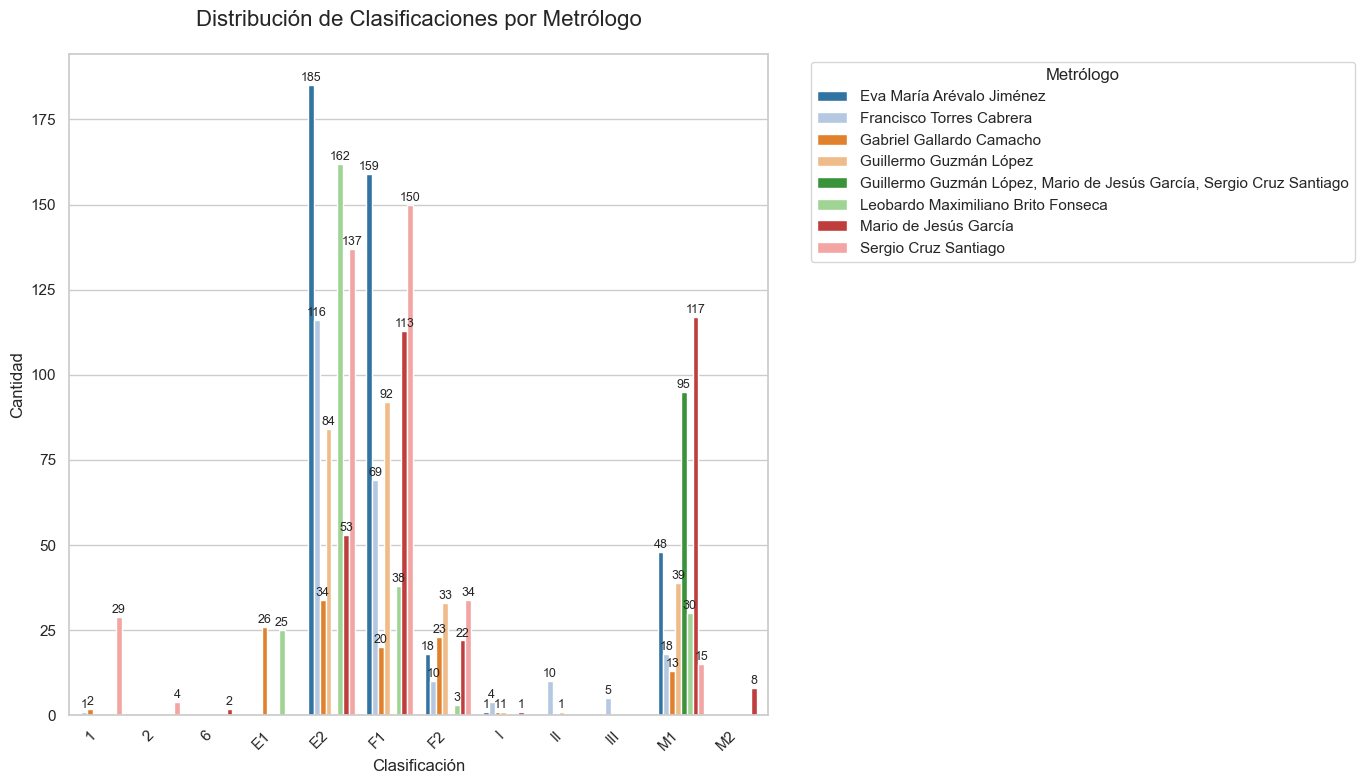

In [410]:
df_melted = met_x_class_nt.reset_index().melt(
    id_vars='classification', 
    var_name='Metrólogo', 
    value_name='Cantidad'
)

# Configurar el estilo
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

# Crear el gráfico de barras agrupadas
barplot = sns.barplot(
    x='classification', 
    y='Cantidad', 
    hue='Metrólogo', 
    data=df_melted,
    palette='tab20',
    ci=None
)

# Personalización
plt.title('Distribución de Clasificaciones por Metrólogo', fontsize=16, pad=20)
plt.xlabel('Clasificación', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Añadir valores en las barras
for p in barplot.patches:
    if p.get_height() > 0:
        barplot.annotate(
            f'{int(p.get_height())}', 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', 
            va='center', 
            xytext=(0, 5), 
            textcoords='offset points',
            fontsize=9
        )

# Mejorar la leyenda
plt.legend(
    title='Metrólogo',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=True
)

# Ajustar layout
plt.tight_layout()
plt.show()

In [398]:
metrologo_por_tipo = (
    mass_sin_errores.groupby(['equipment_type', 'assignee'])['piece_count']
        .sum()
        .unstack(fill_value=0)
        .reset_index()
)

# 4. Calcular el TOTAL correcto (suma de razones)
columnas_errores = metrologo_por_tipo.columns.difference(['equipment_type'])
metrologo_por_tipo['Total'] = metrologo_por_tipo[columnas_errores].sum(axis=1)

# 5. Ordenar y mostrar
metologo_por_tipo = metrologo_por_tipo.sort_values('Total', ascending=False)
metrologo_por_tipo

assignee,equipment_type,Eva María Arévalo Jiménez,Francisco Torres Cabrera,Gabriel Gallardo Camacho,Guillermo Guzmán López,"Guillermo Guzmán López, Mario de Jesús García, Sergio Cruz Santiago",Leobardo Maximiliano Brito Fonseca,Mario de Jesús García,Sergio Cruz Santiago,Total
0,Balanza,1.0,19.0,1.0,2.0,0.0,0.0,1.0,0.0,24.0
1,Pesa ASTM,0.0,1.0,2.0,0.0,0.0,0.0,2.0,33.0,38.0
2,Pesa OIML,410.0,213.0,116.0,248.0,95.0,258.0,313.0,336.0,1989.0


In [399]:
res = pysqldf("""
    SELECT *
    FROM mass_sin_errores
    WHERE report_number = 'CCM0095.M/2025' """)
res

,report_number,so,assignee,calibrator,supervisor,approver,classification,lab_received_date,scheduled_delivery_date,cleaning_date,calibration_date,delivery_date,delivery_time,assigned_time,service_location,priority,piece_count,equipment_type
0,CCM0095.M/2025,I0036,"Guillermo Guzmán López, Mario de Jesús García,...",Mario de Jesús García,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2025-01-14 00:00:00.000000,2025-02-05 00:00:00.000000,2025-01-20 00:00:00.000000,2025-01-24 00:00:00.000000,2025-01-24 00:00:00.000000,8.0,15.0,LAB,ORDINARIO,95.0,Pesa OIML


In [400]:
met_x_type_nt = metrologo_por_tipo.drop(columns='Total', errors='ignore')
met_x_type_nt= met_x_type_nt.set_index('equipment_type')
met_x_type_nt

assignee,Eva María Arévalo Jiménez,Francisco Torres Cabrera,Gabriel Gallardo Camacho,Guillermo Guzmán López,"Guillermo Guzmán López, Mario de Jesús García, Sergio Cruz Santiago",Leobardo Maximiliano Brito Fonseca,Mario de Jesús García,Sergio Cruz Santiago
equipment_type,,,,,,,,
Balanza,1.0,19.0,1.0,2.0,0.0,0.0,1.0,0.0
Pesa ASTM,0.0,1.0,2.0,0.0,0.0,0.0,2.0,33.0
Pesa OIML,410.0,213.0,116.0,248.0,95.0,258.0,313.0,336.0


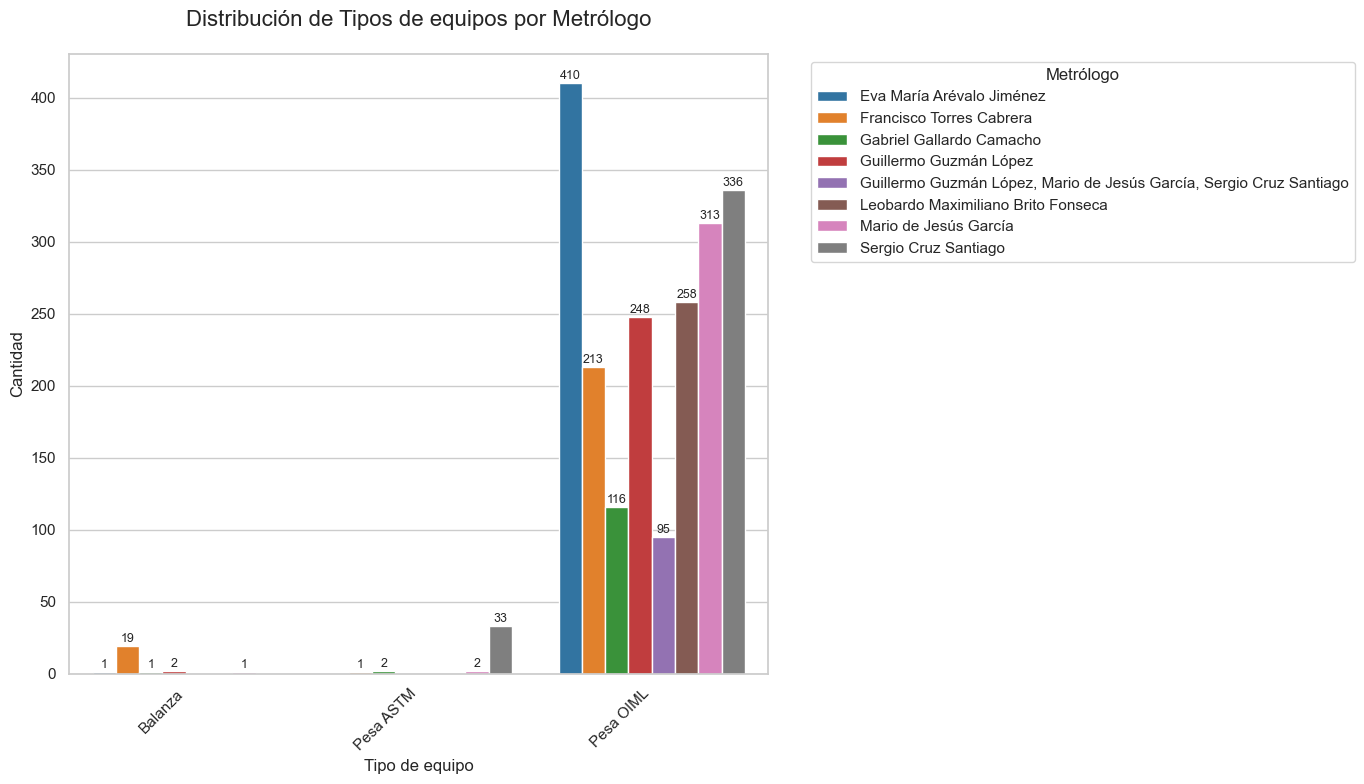

In [401]:
df_melted = met_x_type_nt.reset_index().melt(
    id_vars='equipment_type', 
    var_name='Metrólogo', 
    value_name='Cantidad'
)

# Configurar el estilo
plt.figure(figsize=(14, 8))
sns.set_theme(style="whitegrid")

# Crear el gráfico de barras agrupadas
barplot = sns.barplot(
    x='equipment_type', 
    y='Cantidad', 
    hue='Metrólogo', 
    data=df_melted,
    palette='tab10',
    errorbar=None
)

# Personalización
plt.title('Distribución de Tipos de equipos por Metrólogo', fontsize=16, pad=20)
plt.xlabel('Tipo de equipo', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Añadir valores en las barras
for p in barplot.patches:
    if p.get_height() > 0:
        barplot.annotate(
            f'{int(p.get_height())}', 
            (p.get_x() + p.get_width() / 2., p.get_height()), 
            ha='center', 
            va='center', 
            xytext=(0, 5), 
            textcoords='offset points',
            fontsize=9
        )

# Mejorar la leyenda
plt.legend(
    title='Metrólogo',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=True
)

# Ajustar layout
plt.tight_layout()
plt.show()

In [413]:
class_del_time = mass_sin_errores.groupby(['classification'])['delivery_time'].mean().reset_index()
class_del_time

,classification,delivery_time
0,1,12.500000
1,2,14.000000
2,6,5.000000
3,E1,37.333333
4,E2,11.626761
5,F1,8.796296
6,F2,9.047619
7,I,2.125000
8,II,1.727273
9,III,1.200000


In [403]:
class_del_time = mass_sin_errores.groupby(['classification'])['delivery_time'].mean().reset_index()
class_del_time

,classification,delivery_time
0,1,12.500000
1,2,14.000000
2,6,5.000000
3,E1,37.333333
4,E2,11.626761
5,F1,8.796296
6,F2,9.047619
7,I,2.125000
8,II,1.727273
9,III,1.200000


C:\Users\Miguel Oscar\AppData\Local\Temp\ipykernel_17948\3813255021.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


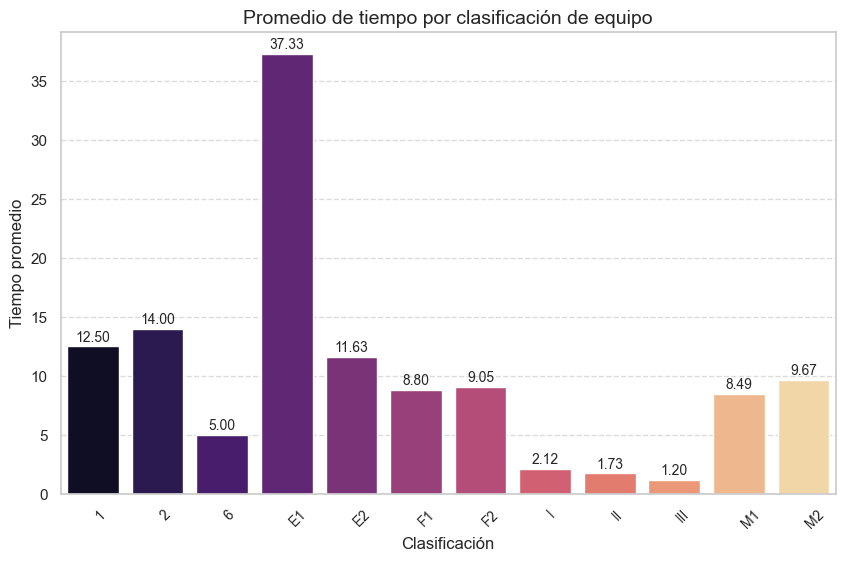

In [427]:

plt.figure(figsize=(10, 6))
# Sintaxis básica
ax = sns.barplot(
    x='classification',  # Variable categórica (eje x)
    y='delivery_time',   # Variable numérica (eje y)
    data=class_del_time,
    #estimator='mean',  # Función de agregación (mean, sum, median, etc.)
    palette='magma',            # Intervalo de confianza (o 'sd' para desviación estándar)
    #color='blue'       # Color de las barras
)

# Añadir los valores en las barras
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        x=bar.get_x() + bar.get_width() / 2,  # Posición horizontal centrada
        y=height + 0.2,                       # Posición vertical (altura + offset)
        s=f"{height:.2f}",                    # Texto (2 decimales)
        ha="center",                           # Alineación horizontal
        va="bottom",                           # Alineación vertical
        fontsize=10
    )

plt.title("Promedio de tiempo por clasificación de equipo", fontsize=14)
plt.xlabel("Clasificación", fontsize=12)
plt.ylabel("Tiempo promedio", fontsize=12)
plt.xticks(rotation=45, ha='left', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Solo líneas de cuadrícula en el eje y

plt.show()

In [436]:
res = pysqldf("""
    SELECT report_number, assignee, calibrator, classification, delivery_time, assigned_time, piece_count
    FROM mass_sin_errores
    WHERE classification = 'E1' """)
res

,report_number,assignee,calibrator,classification,delivery_time,assigned_time,piece_count
0,CCM1700.M/2024,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,E1,44.0,30.0,25.0
1,CCM1759.M/2024,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E1,34.0,30.0,1.0
2,CCM1760.M/2024,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E1,34.0,30.0,25.0


In [404]:
time_per_type_met = (
    mass_sin_errores.groupby(['equipment_type', 'calibrator'])['delivery_time']
        .mean()
        .unstack(fill_value=0)
        .reset_index()
)

'''# 4. Calcular el TOTAL correcto (suma de razones)
columnas_errores = metrologo_por_tipo.columns.difference(['equipment_type'])
metrologo_por_tipo['Total'] = metrologo_por_tipo[columnas_errores].sum(axis=1)

# 5. Ordenar y mostrar
metologo_por_tipo = metrologo_por_tipo.sort_values('Total', ascending=False)
metrologo_por_tipo'''

time_per_type_met

calibrator,equipment_type,Eva María Arévalo Jiménez,Francisco Torres Cabrera,Gabriel Gallardo Camacho,Guillermo Guzmán López,Leobardo Maximiliano Brito Fonseca,Mario de Jesús García,Sergio Cruz Santiago
0,Balanza,0.000000,1.684211,2.000000,3.000000,0.000000,0.000000,0.000000
1,Pesa ASTM,0.000000,7.000000,18.000000,0.000000,0.000000,5.000000,14.000000
2,Pesa OIML,8.827586,8.637931,12.254545,11.555556,11.931034,8.568182,7.466667


In [405]:

mass_sin_errores['assignee'].unique()

array(['Leobardo Maximiliano Brito Fonseca', 'Francisco Torres Cabrera',
       'Guillermo Guzmán López', 'Eva María Arévalo Jiménez',
       'Sergio Cruz Santiago', 'Mario de Jesús García',
       'Gabriel Gallardo Camacho',
       'Guillermo Guzmán López, Mario de Jesús García, Sergio Cruz Santiago'],
      dtype=object)

In [406]:
res = pysqldf("""
    SELECT report_number, assignee, calibrator, classification, piece_count, assigned_time
    FROM mass_sin_errores 
    WHERE assignee <> calibrator
    
    """)
res

,report_number,assignee,calibrator,classification,piece_count,assigned_time
0,CCM0012.M/2025,Eva María Arévalo Jiménez,Francisco Torres Cabrera,E2,3.0,21.0
1,CCM0013.M/2025,Sergio Cruz Santiago,Gabriel Gallardo Camacho,E2,24.0,21.0
2,CCM0015.M/2025,Eva María Arévalo Jiménez,Gabriel Gallardo Camacho,E2,1.0,21.0
3,CCM0016.M/2025,Eva María Arévalo Jiménez,Gabriel Gallardo Camacho,E2,9.0,21.0
4,CCM0026.M/2025 v0,Eva María Arévalo Jiménez,Gabriel Gallardo Camacho,E2,1.0,4.0
...,...,...,...,...,...,...
69,CCM0317.M/2025,Eva María Arévalo Jiménez,Francisco Torres Cabrera,E2,1.0,14.0
70,CCM0340.M/2025,Mario de Jesús García,Leobardo Maximiliano Brito Fonseca,E2,1.0,14.0
71,CCM0341.M/2025,Mario de Jesús García,Leobardo Maximiliano Brito Fonseca,E2,1.0,14.0
72,CCM0374.M/2025,Eva María Arévalo Jiménez,Gabriel Gallardo Camacho,I,1.0,0.0
